# VAD

author: steeve LAQUITAINE

date: 04/08/2021


## Abstract

Voice activity detection is critical to reduce the computational cost of continuously monitoring large volume of speech data necessary to swiftly detect command utterances such as wakewords. My objective was to code a Voice Activity Detector (VAD) with reasonable performances (Low false rejection rate) based on a neural network within a week and with low computing resources. The model was trained and tested on labelled data from LibriSpeech prepared by SONOS. I used TensorFlow to develop the model and tested several common VAD modifications such as smoothing, minimum speech time, hangover scheme [TODO]. I relied on a set of diverse development and visualization tools to make sense of the data, clean the data and inspect the inner workings of the model and the pipelines. Future work will integrate additional existing speech and noise datasets (some can be found on http://openslr.org). I strived to go beyond just solving the challenge itself.

## Method

### Performance metrics

I used False rejection rate (FRR) as the key measure of model performance. FRR also called False negative rate or miss rate equates to 1 - Recall and is calculated as:

$$
FRR = \frac{FN}{FN + TP}
$$

where "FN", for false negatives are incorrect rejection of speech and TP, for True positives are correct detections of speech.

My reasoning was that: 

- the main goal is not to miss speech periods to maximize users satisfaction:
- it is widely used in most paper in the field

The disadvantage of greedily maximizing that metrics is that it could train a model that detects everything as speech, generating lots of false positive, a poor user experience. It is also very computationally expensive.

### Dataset

The dataset contains 1914 files separated in 957 .wav audio files associated with a label file (n=957) with the same name.

### Model implementation

In [1]:
# Move to project path
import os
os.chdir(context.project_path)

# import dependencies
import os
import scipy
import glob
import time
import pandas as pd
import numpy as np
from collections import Counter

# run kedro pipelines
from kedro.io import DataCatalog, MemoryDataSet
from kedro.runner import SequentialRunner
from vad.pipelines.data_eng import pipeline as data_eng
from vad.pipelines.inference import pipeline as inference
from vad.pipelines.evaluate import pipeline as evaluate
from kedro.pipeline import Pipeline
import mlflow
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset

# ignore warnings for esthetics
import warnings
warnings.filterwarnings('ignore')

# set plot params
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 22}) # must set in top
sns.set(style="whitegrid", font_scale=2)

/Users/steeve_laquitaine/Desktop/vad/src/vad/pipelines/data_eng/nodes.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(conf)


#### Neural network architecture:

Due to poor computational power, I develop on a laptop, I chose to test minimal network architectures containing up to two hidden layers and a dense binary classification layer. I show the single GRU layer's network's conceptual graph generated by the tensorboard api below.

After cloning the project's repository, the graph can be loaded in your web browser by running the command below in a linux (or MacOS unix) terminal: 

```bash
cd ../vad
tensorboard --logdir tbruns
```

where ../vad is the clone repository directory.

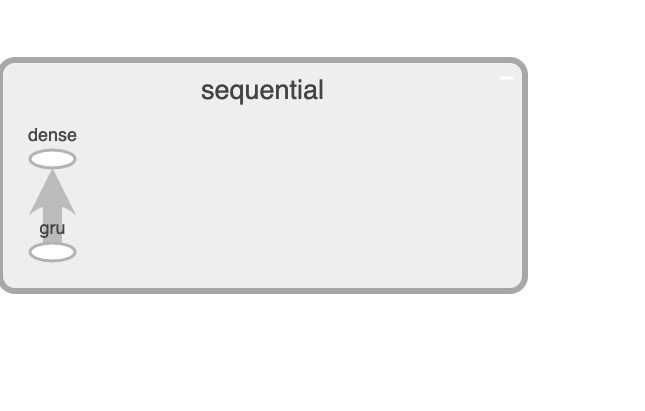

In [2]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/tb_conceptual_graph.png') 

I show below a more detailed description of the network layers generated with tensorflow keras' plot_model() api.

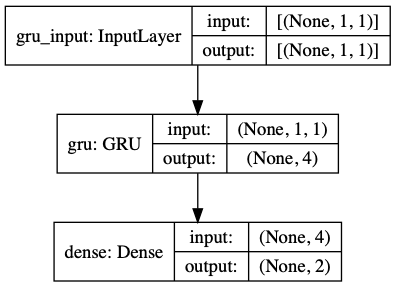

In [3]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/keras_model_architecture.png') 

I show below the model's number of trainable and non-trainable parameters:

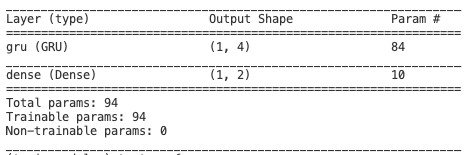

In [4]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/summary_params.png') 

## Experiments

### Approach

I chose to implement the simplest modeling approach in order to ensure quick iterations and debugging. My approach was based on sequential hypothesis testing.

**Does a minimal model perform better than chance ?**

I first extracted a small sample of the real data to get fast training at the expense of performance. I trained a simple 1-layer GRU model which takes as input a single batch with one look-back timestep and projects to a fully connected binary classification layer with a softmax activation function. I first trained the model with one epoch. I used `Adam`, an adaptive optimizer that is well known to handle the complex training dynamics of recurrent networks better than simple gradient descent optimization. Training the model on a 2.8 secs audio from one speaker (20% of the full audio chunk) took 50 secs.

**Is more layers better than less ?** 

I expected that a 1-layer network would perform better than a 2-layer network a deeper network enable the model to capture more non-linearity in the data, but both models produced had similar performance and a 1-layer GRU did not train faster than a 2-layer net.

**Lower resolution better speed?**: 

I tested two data encoding resolutions: float16 and float32 bits. Both resolution took the same time to train.

**Does learning from more timesteps reduce performance ?**: 

I tested 1, 2, 10 and 320 timesteps which correspond to 0.06 ms, 0.12 ms, 1.2 ms and 20 ms with the current sampling rate of 16 Khz.
- Moving from 1 (50 sec training) to 2 timesteps (2 min trainin) produced a 2.5 fold improvement in FRR from 1 timestep (0.34 on average to 0.14) over subjects
- FRR improved by 20% from 2 to 10 timesteps which took 5 min to train.
- Training on 1 timesteps took about 50 secs, on 10 timesteps 90 secs.
- 320 timesteps took too long to train within the given time constrains and was stopped.

**Performance vs. train-test split ?**: 

Performance drastically increased from 0 all over to 0.8-ish train from a 0.5 split to a 0.7. Performance was same for 1 or 2 GRU.

**How long to convergence ?**:  

The loss curve suggests that 7 epoches are enough for convergence (shoulder of the curve).

**The more data the better ?**: 

I trained the model on 20% vs 100% of train set for 7 epochs
  * same results across nb GRU
  * metrics:
    * 100% has:   
      * 15% better recall (86%)
      * 10% lower precision (85%)
      * 4% better f1 (86%)

**Does training on 2 secs audio perform well ?**: 

I trained the model on one 2.8 secs from one speaker's audio (19-198-0003.wav) and tested how well the model generalizes to his other audio chunks and other speakers' audios:

- I trained on speaker 0 (19-198) and predicted on a sample of other test audio chunks from the same speaker. The test performance were about 0.85 f1-score.

I tested how well the model prediction generalize to other speakers audio:

- I trained on speaker 0 (19-198) and predicted on two other persons' audio chunks (103-1240-0001, 118-47824-0000). As a result: 

    - 103-1240-0001: 
      - I observed an increase in false rejection rate (50% only compared to ~30%)
      - candidate explanation: other person could speak with lower average amplitudeshorter speech periods which would lead the model to miss speeches
      
    - 118-47824-0000:
      - False rejection rate was the same 

- Synthetic vs. person
    - train on person 1 - predict on synthetic (1263-141777-0000)
        - result: FRR was good

- Loud vs. low voice
    - train on person 1 - predict on human (1447-130551-0019)
        - kept good f1 score 0.7 with good recall and reasonable precision (0.6)

- normal vs. high pace
    - I train on speaker 1 - predict on human (1578-6379-0017)
    - kept good f1 score with good recall and reasonable precision

**Which activation sigmoid (default) vs. biased Softmax ?** 

False rejection rate was slightly lower (from 13% to 9% on other subjects test audios) for biased softmax at the dense layer than for the default sigmoid activation function. So I retained Bias softmax.
The speed of convergence remained unchanged.

**Is Inference fast enough ?** 

Inference took 12.6 sec on a 15 sec audio that is 840 ms / sec.


### A few sanity checks

I tested the inference pipeline:

1. Audio label mapping was shuffled
    - result: FRR worsened to 40% (possibly not significantly different from chance).

2. I tested a dummy model that always predicts "speech":
    - result: FRR worsened to 0.4 (precision was high which is expected if labels are imbalanced toward speech)

3. I tested a dummy model that always predicts "no speech":
    - result: FRR worsened to 100%, together with precision.
    
I tested the train pipeline by shuffling the audio label-mapping:

  - As expected:        
    - FRR was 100% and precision 0%
    - there was virtually no reduction in loss over epochs indicating no learning

### Final setup

Training dataset:

- 2.8 secs audio from one speaker: this small chunk took 4 min to train while using a full 15 secs audio file (i.e., 5 times more data) took 20 min for a 10% performance improvement.

Architecture:

- 1-layer GRU: Occam's razor principle favors simplicity given the same performance
- Softmax with initial bias to couterbalance the label bias  

Training:

- 1 batch 
- 10 timesteps    
- at least 7 epochs 
- split_frac: 0.7 : had the biggest effect on performance (0 at 0.5 to 0.7 at 0.7)

## Results

### Description of the audio data

#### There are several speakers

Listening to a sample of the audio files revealed that a variety of speakers

- Humans
    - men
    - women
- Synthetic
    - men
    - women

I also characterised speeches by their variety of amplitudes and pace
- Normal vs fast pace  
- Loud vs, low volume

We show below the best typical example of an audio signal (top panel). and its associated speech labels "1" for speech and "0" for no speech (bottom panel).

All audio signals were 32 bits float single channel time series. We run a few sanity checks:

In [5]:
# load all data
data_path = "data/01_raw/vad_data/"
audio_files = glob.glob(f"{data_path}*.wav")
audio_files.sort()
label_files = glob.glob(f"{data_path}*.json")
label_files.sort()

# run sanity test on file-label name mapping and sorting
correct_mapping = []
for aud, lbl  in zip(audio_files, label_files):
    correct_mapping.append(os.path.splitext(aud)[0] == os.path.splitext(lbl)[0])
print(f"- the {sum(correct_mapping)} label files were correctly mapped with the {len(audio_files)} audio files")

- the 957 label files were correctly mapped with the 957 audio files


- Number: 34 speakers
- Speakers'ID: ['103' '1034' '1040' '1069' '1081' '1088' '1098' '1116' '118' '1183'
 '1235' '1246' '125' '1263' '1334' '1355' '1363' '1447' '1455' '150'
 '1502' '1553' '1578' '1594' '1624' '163' '1723' '1737' '1743' '1841'
 '1867' '1898' '19' '1926']


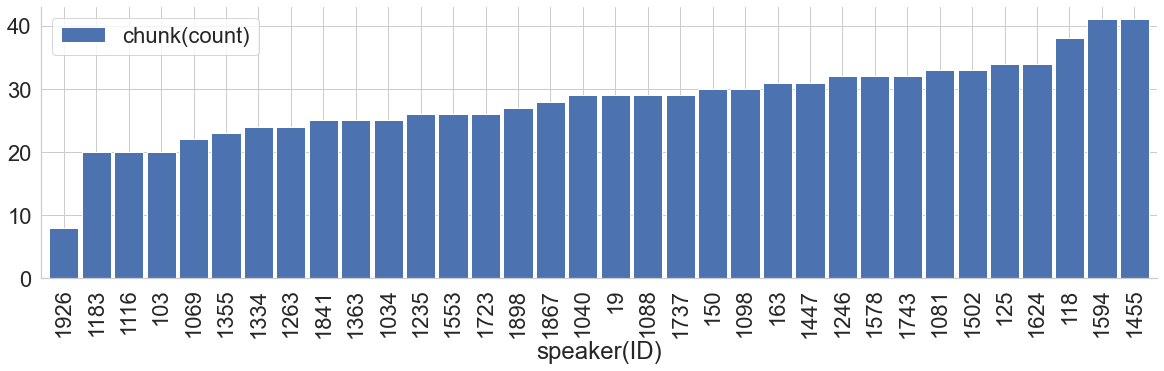

In [6]:
# get speaker info
file_speaker = [os.path.basename(file).split("-")[0] for file in audio_files]
speaker_set = np.unique(file_speaker)
print("- Number:", len(speaker_set), "speakers")
print("- Speakers'ID:", speaker_set)

# get number of chunks per speaker
speaker, nb_chunks = zip(*Counter(file_speaker).items())
counts = pd.DataFrame(data=(speaker, nb_chunks), index=["speaker(ID)", "chunk(count)"]).T
counts.sort_values(by="chunk(count)").plot.bar(x="speaker(ID)", figsize=(20, 5), width=0.9);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [7]:
# define a few useful functions
def read_X(audio_path):
    sample_rate, data = scipy.io.wavfile.read(
        audio_path
    )
    sample_size = len(data)
    time_unit = 1 / sample_rate
    duration_in_sec = time_unit * len(data)
    timestamp = np.arange(0, len(data), 1) * time_unit
    return {
        "audio": {
            "data": data.reshape(sample_size, 1),
            "metadata": {
                "sample_rate": sample_rate,
                "sample_size": sample_size,
                "time_unit": time_unit,
                "duration_in_sec": duration_in_sec,
                "timestamp": timestamp,
            },
        }
    }
    
def load_Y(label_path):
    return pd.read_json(label_path)    

def sync_audio_and_labels(audio, label):

    # get data
    data = audio["audio"]["data"]
    time_unit = audio["audio"]["metadata"]["time_unit"]
    sample_size = audio["audio"]["metadata"]["sample_size"]

    # create timestamps
    audio["audio"]["metadata"]["timestamp"] = np.arange(0, len(data), 1) * time_unit

    # case label exists
    # synchronize labels with audio
    synced_label = np.zeros((sample_size, 1))
    array = label.values
    for ix in range(array.shape[0]):
        interval = array[ix][0]
        speech_start = interval["start_time"]
        speech_end = interval["end_time"]
        span = np.where(
            np.logical_and(
                audio["audio"]["metadata"]["timestamp"] >= speech_start,
                audio["audio"]["metadata"]["timestamp"] <= speech_end,
            )
        )
        synced_label[span] = 1
    audio["label"] = synced_label
    return audio

def load_synced_audio_and_label(audio_path, label_path):
    audio = read_X(audio_path)
    label = load_Y(label_path)
    return sync_audio_and_labels(audio, label)
    
def plot_labelled_audio(timestamp, audio, labels, n_sample):
    # plot audio
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,5))
    ax1.plot(timestamp, audio[:n_sample], "r-")

    # plot label
    ax2.plot(timestamp, labels[:n_sample], "b-")
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    ax1.tick_params(labelsize=8)

    return f, ax1, ax2

We show below a few interesting example chunks for two speakers.
- Audio seem well labelled (see supplementary).
- Background noise is low and stationary.


SPEAKER 19
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


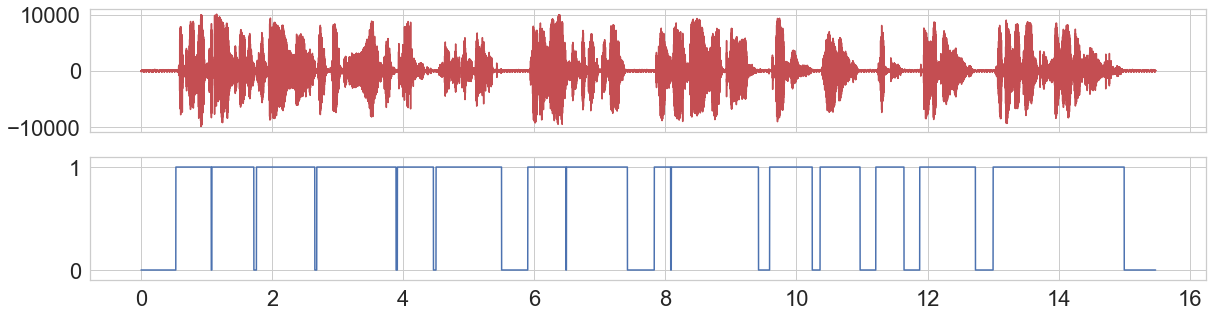

SPEAKER 103
  data/01_raw/vad_data/103-1241-0027.wav
  data/01_raw/vad_data/103-1241-0027.json


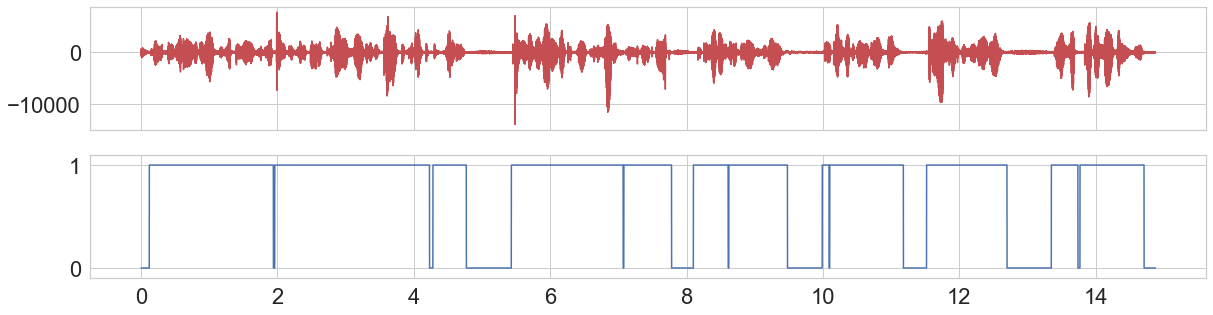

In [8]:
# show an example per speaker
exple_pos = [920, 17]

# sync audio and labels
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]}")
    print(" " , audio_files[exple])
    print(" " , label_files[exple])    
    audio = load_synced_audio_and_label(audio_files[exple], label_files[exple])
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )

We validated that all audio files were associated with a .json label file.


In [9]:
# data quality check
print("- audio file sample size:", len(audio_files))
print("- label file sample size:", len(label_files))

- audio file sample size: 957
- label file sample size: 957


The entire sample could be loaded quickly:

In [10]:
# loading
tic = time.time()
audio_data = [scipy.io.wavfile.read(audio) for audio in audio_files]
print("- loading duration:", np.round(time.time()-tic,2), "sec")

- loading duration: 2.35 sec


Sample size and sampling rate:

In [11]:
# get sample rate per audio
sample_rates = [audio for audio in np.array(audio_data)[:,0]]
sample_rate = np.unique(sample_rates)
print("Sample rate information:")
print("-", len(sample_rate), "sample rate(s)")
print("- rate:", np.unique(sample_rates)[0], "Hz")

Sample rate information:
- 1 sample rate(s)
- rate: 16000 Hz


We kept the signal at 16Khz which is enough to cover the frequency range of human speech according to the literature (Human voice b/w `85hz to 8khz` [REF], hearing b/w `20 hz to 20kh`[REF]).

In [12]:
# get sample size per audio
sample_sizes = [len(audio) for audio in np.array(audio_data)[:,1]]
print("Sample size information:")
print("-", len(np.unique(sample_sizes)), "sample size(s)")
print("- max:", max(sample_sizes), "samples (", max(sample_sizes)/sample_rate, "secs)")
print("- min:", min(sample_sizes), "samples (", min(sample_sizes)/sample_rate, "secs)")
print("- median:", np.median(sample_sizes), "samples (", np.median(sample_sizes)/sample_rate, "secs)")

Sample size information:
- 711 sample size(s)
- max: 275280 samples ( [17.205] secs)
- min: 22560 samples ( [1.41] secs)
- median: 222080.0 samples ( [13.88] secs)


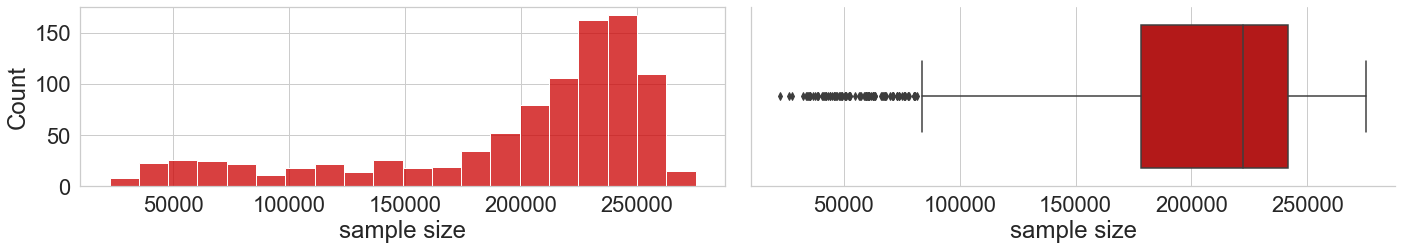

In [13]:
# psample size distribution
# plot SNR
df_size = pd.DataFrame(sample_sizes, columns=["sample size"])
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4))
# histogram
sns.histplot(ax=ax1, data=df_size, x="sample size", color=[.8,0,0])
# box plot
sns.boxplot(ax=ax2, x=df_size["sample size"], color=[.8,0,0])
plt.tight_layout()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

**Signal amplitudes**: the true decibel amplitude of the audio will depend on each speaker's microphone characteristics, the speaker's distance to its microphone, the speaker's volume configuration. Having no acces to these information we did not derive the true decibel amplitude (dB) from the raw audio signal amplitude or compared absolute amplitudes between speakers. Rather we compared the signals' signal-to-noise ratio (SNR).

### Speech signals are nearly pure

I made the naive assumption that audio can be linearly decomposed as the sum of independent speech and noise amplitude components. This assumption would not hold in case of reverberation.

$$audio = speech + noise $$

Where i respectively categorize noise as the portion of the audio that is not labelled as speech. Thus:

$$speech = audio - noise$$

The signal to noise ratio in decibel is given by: 

$$SNR = 20.log_{10}(\frac{speech\_rms}{noise\_rms})$$

where speech\_rms and noise\_rms are the root mean square of the speech_signal and of the noise



In [14]:
# define some useful functions
def get_noise_rms(audio_path, label_path):
    synced = load_synced_audio_and_label(audio_path, label_path)
    audio = synced["audio"]["data"]
    audio = audio.astype("float32")
    label = synced["label"]    
    noise = audio[label==0]
    return np.sqrt(np.mean(noise**2))

def denoise_speech(audio_path, label_path):
    synced = load_synced_audio_and_label(audio_path, label_path)
    audio = synced["audio"]["data"]
    audio = audio.astype("float32")    
    label = synced["label"]    
    noise = audio[label==0]
    # dampen signals below max noise amplitude to 0
    speech = audio.copy()
    max_noise = max(noise)
    min_noise = min(noise)
    speech[np.logical_and(speech<=max(noise), speech>=min(noise))] = 0    
    return audio, speech 

def get_speech_rms(audio_path, label_path):
    audio, speech = denoise_speech(audio_path, label_path)
    return np.sqrt(np.mean(speech**2))

def plot_denoised_speech(audio, denoised_speech):
    # plot audio
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,6));
    ax1.plot(audio, "r-");
    ax1.set_title("Raw audio");

    # plot denoised speech
    ax2.plot(denoised_speech, "b-");
    ax2.set_title("Denoised audio");    
    ax1.tick_params(labelsize=8);
    ax2.set_xlabel("timestamp (sample)");
    plt.tight_layout();
    plt.show();

def get_snr(n_rms, s_rms):
    return 20*np.log10(s_rms / n_rms)

In [15]:
snrs = []
for ix in range(len(audio_files)):
    n_rms = get_noise_rms(audio_files[ix], label_files[ix])
    s_rms = get_speech_rms(audio_files[ix], label_files[ix])
    snr = get_snr(n_rms, s_rms)
    snrs.append(snr)

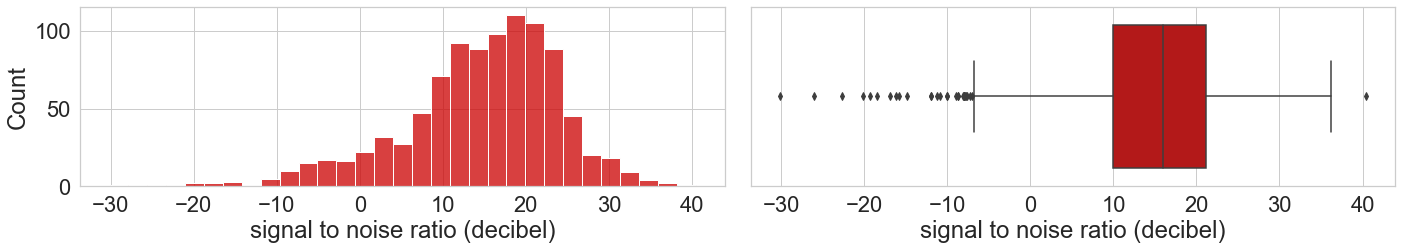

In [16]:
# plot SNR
df_snr = pd.DataFrame(snrs, columns=["signal to noise ratio (decibel)"])
df_snr = df_snr.replace([-np.inf], np.nan)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4))
# histogram
sns.histplot(ax=ax1, data=df_snr, x="signal to noise ratio (decibel)", color=[.8,0,0])
# box plot
sns.boxplot(ax=ax2, x=df_snr["signal to noise ratio (decibel)"], color=[.8,0,0])
plt.tight_layout()

I show below what noise dampening (blue in bottom panel) does to the raw signal below (red, in top panel)
for an example audio file.

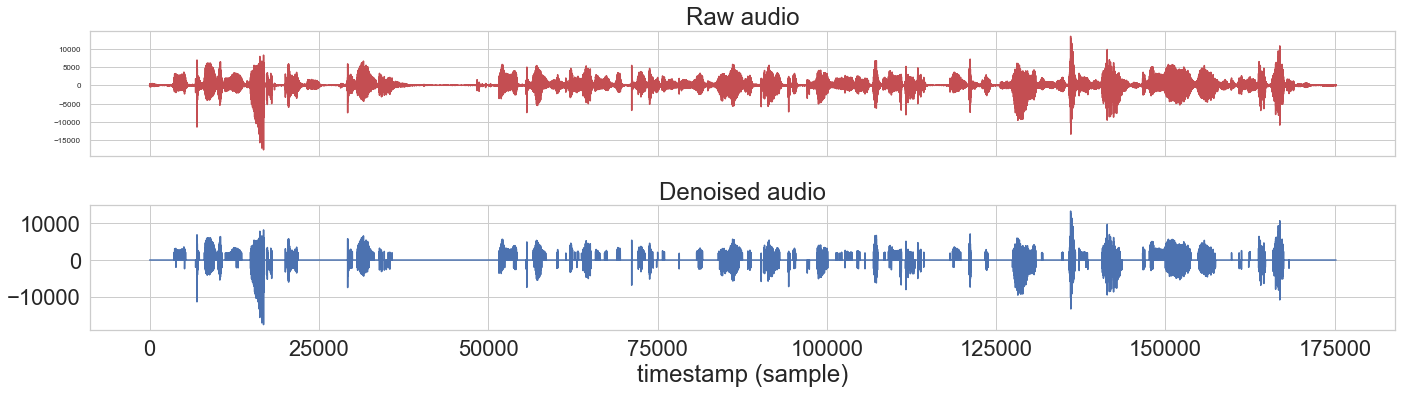

In [17]:
audio, denoised_speech = denoise_speech(audio_files[ix], label_files[ix])
plot_denoised_speech(audio, denoised_speech)

### Speech and no-speech classes are imbalanced in the training dataset

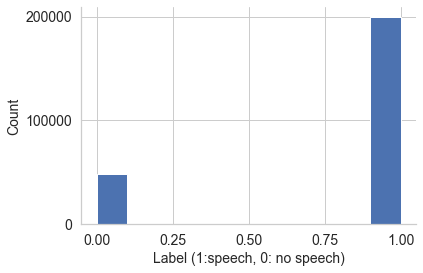

In [18]:
train_audio_path = "data/01_raw/vad_data/19-198-0003.wav"
train_label_path = "data/01_raw/vad_data/19-198-0003.json"
data = load_synced_audio_and_label(train_audio_path, train_label_path)
plt.hist(data["label"]);
plt.xlabel("Label (1:speech, 0: no speech)", fontsize=14);
plt.ylabel("Count", fontsize=14);
plt.xticks(fontsize=14); 
plt.yticks(fontsize=14);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

### The 1-layer GRU net converges within 7 epochs

I monitored training quality in Tensorboard api. I display below the loss curve calculated for 7 training epochs (x-axes ranging from 0 to 6) on training dataset (dark curve) and validation dataset (blue curve). The model was trained with 10 timesteps look-back (see logged runs in tensorboard for vad-1-gru-20210901-131436/train/train, vad-1-gru-20210901-131436/train/validation in tensorboard web api). Categorical cross-entropy on training data was not flat as expected from a model that doesn't learn but goes down until convergence near the 7th epoch.

I also monitored recall to evaluate improvement in recall (decrease in FRR) over training. Recall increased (thus FRR decreased) by 10% within 7 epochs and took about 4 epochs to converge on the training dataset. Recall on validation was already high since the first epoch and remained stable over training (see logged runs in tensorboard for vad-1-gru-20210901-131436/train/train, vad-1-gru-20210901-131436/train/validation).

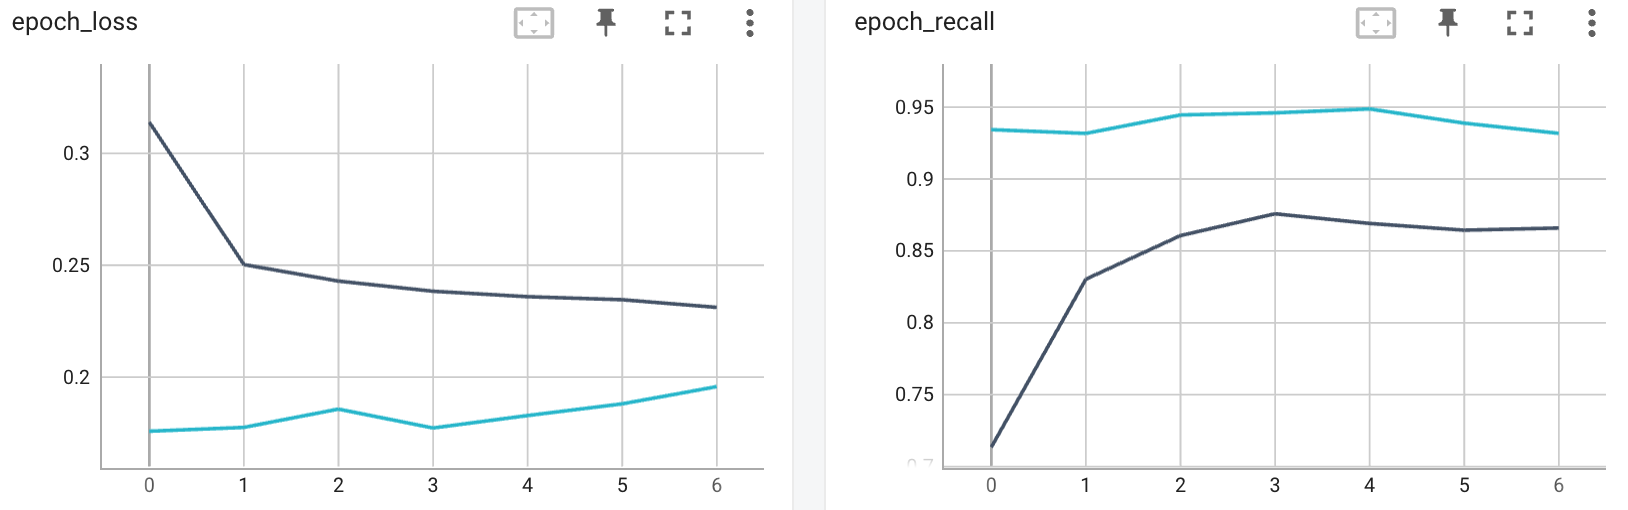

In [19]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/loss_recall_per_epoch.png') 

### Weights and biases follow well-behaved multimodal distributions 

Both the Gru and dense layer show distribution that did not get stuck at 0 values and did not display large outlier values. This suggests that our GRU units successfully circumvented the vanishing gradient problem that is typical of more traditional RNN.

**Gru layer**

The GRU l layer has 3 types of trainable parameters:
- weights ("kernel_0")
- recurrent weights ("kernel_0")
- biases ("kernel_0")

I will refer to iterations as epochs as for a single batch, iterations equal the number of epochs.

- Weight and bias values 
    - The weight distribution was very sparse with the majority of weights being null and some values being spread at negative and positive values.
    - GRU layer's biases and recurrent weights slightly changed over epochs (y-axis), spreading across a larger range of values.

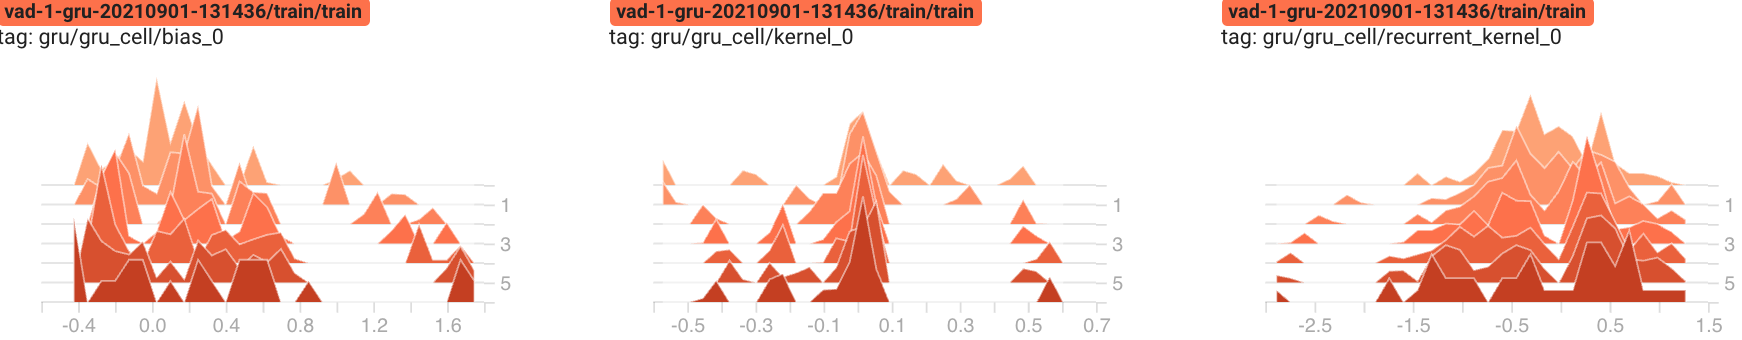

In [20]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_gru_weights_hist_per_iter.png') 

These changes in the bias and weights distributions are more apparent on the plot of the weight values against epochs (different shading columns represent the distributions' 90th, 60th percentiles ...)
(x-axis).

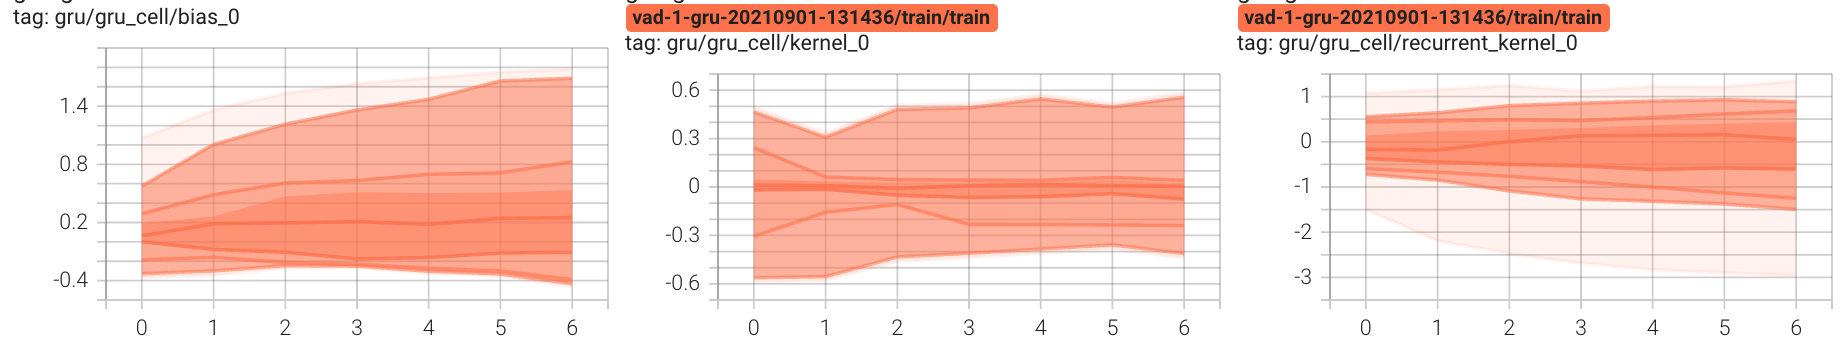

In [21]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_gru_weights_hist_per_epoch.png') 

**Dense layer**

- Dense layer's weights and biases did not get not stuck at 0 and did not display large outlier values.
    - Biases followed a bi-modal distributions with some weights at -1, others peaking at -0.3 and other at +0.3. There are no outlier biases.
    - Weights followed a tri-modal distributions with some weights at -1, a small majority peaking at 0 and some peaking at +1.5. There were no outlier bias values.

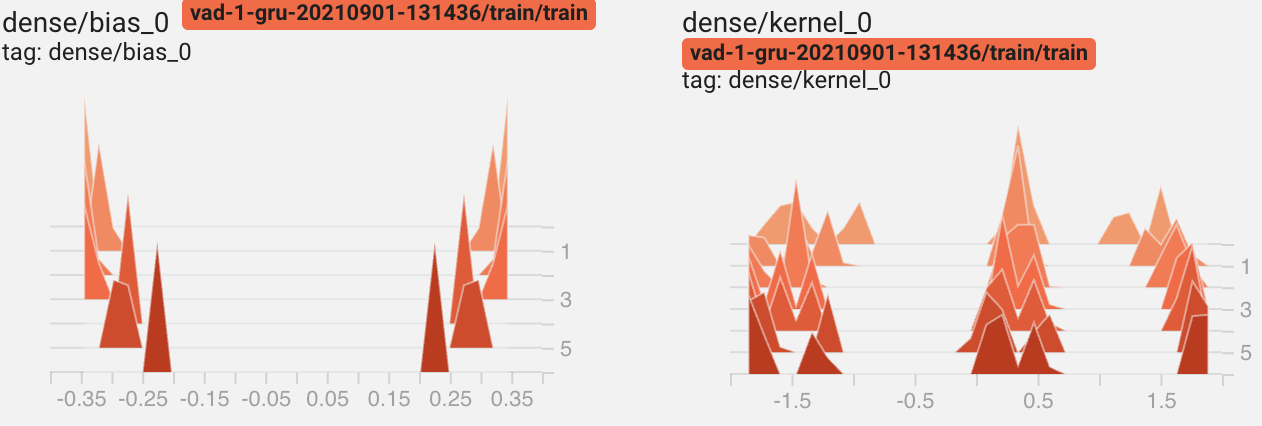

In [22]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_dense_hist_per_iter.png') 

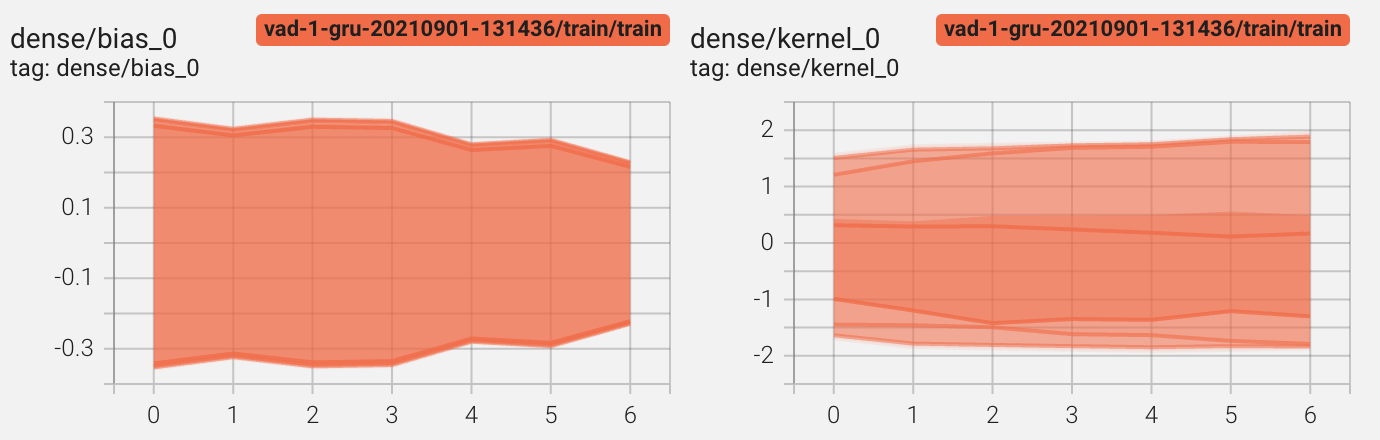

In [23]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_dense_hist_per_epoch.png') 

### A simple GRU RNN predicts well

I first trained the model on a small chunk (2.8 secs) of one speaker data and I tested it on one full audio for each of the 34 speakers' (about 3.5 min, for 15 sec inference per audio file). I chose the first audio for simplicity. Further analyses must assess whether the first audio is representative of the other audios for each speaker. I chose a sample and not the entire dataset because inference would take more than 3 hours on the 957 files. I show below the distribution of the best model's False rejection rates over the sample test dataset. 

In [24]:
# define data engineering pipeline
from kedro.pipeline import Pipeline, node
from vad.pipelines.data_eng.nodes import Etl, DataEng

def run_data_eng(**kwargs):
    return Pipeline(
        [
            node(
                func=Etl.test_on_label,
                inputs=["synced", "params:TEST"],
                outputs="tested",
                name="test_label",
            ),
            node(
                func=DataEng.set_resolution,
                inputs=["tested", "params:DATA_ENG"],
                outputs="floated32",
                name="float_and_32bit",
            ),
            node(
                func=DataEng.reshape_input_for_net,
                inputs=["floated32", "params:DATA_ENG"],
                outputs="prod_audio",
                name="reshape_for_net",
            ),
        ]
    )

I display below the sequential steps performed by my inference pipeline and the False rejection rates for all audio signals in the database.

In [ ]:
# run inference pipeline
runner = SequentialRunner()
FRRs = []
precisions = []
f1s = []
accuracys = []
labels = []
predictions = []

_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)

for exple in exple_pos:
    tic = time.time()
    
    # track experiments
    mlflow.set_experiment("/explore")
    mlflow.end_run()
    with mlflow.start_run():

        # set inference pipeline parameters
        DATA_ENG = MemoryDataSet(data={
                     "LABEL": True,
                     "REDUCE_TRAIN": False,
                     "TIMESTEPS": 1,
                     "N_CLASSES": 2,
                     "RESOLUTION": "float16",
                 })
        TEST = MemoryDataSet(data={
              "SHUFFLE_LABEL": False, # must be false: random audio-label mapping
              "ALL_SPEECH": False, # must be false: random audio-label mapping
              "NO_SPEECH": False, # must be false: random audio-label mapping  
             })

        # load and sync data to predict
        synced = load_synced_audio_and_label(audio_files[exple], label_files[exple])
        synced = MemoryDataSet(data=synced)

        # load trained model
        model = TensorFlowModelDataset(filepath="data/06_models/model")

        # config. pipeline datasets and parameters inputs
        io = DataCatalog(data_sets={
                                    'params:DATA_ENG': DATA_ENG,
                                    'params:TEST': TEST, 
                                    "model": model,
                                    "synced": synced
                                   }
                        )

#       # build pipeline
        pipeline = Pipeline(
            [
                run_data_eng(), 
                inference.run(), 
                evaluate.run()
            ]
        )

        # get label
        label = runner.run(pipeline.to_nodes("reshape-label"), catalog=io)        

        # compute prediction        
        prediction = runner.run(pipeline.to_nodes("reshape-prediction"), catalog=io)

        # compute metrics
        metrics = runner.run_only_missing(pipeline, io)

        # record
        labels.append(label)        
        predictions.append(prediction)
        FRRs.append(metrics["metrics"]["false_rejection_rate"].item())
        precisions.append(metrics["metrics"]["precision"].item())
        f1s.append(metrics["metrics"]["f1"].item())
        accuracys.append(metrics["metrics"]["accuracy"].item())        
        print(np.round(time.time()-tic,2), "secs")

2021-09-02 14:12:02,482 - kedro.io.data_catalog - INFO - Loading data from `synced` (MemoryDataSet)...
2021-09-02 14:12:02,485 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2021-09-02 14:12:02,491 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-02 14:12:02,493 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-02 14:12:02,500 - kedro.runner.sequential_runner - INFO - Completed 1 out of 4 tasks
2021-09-02 14:12:02,501 - kedro.io.data_catalog - INFO - Loading data from `tested` (MemoryDataSet)...
2021-09-02 14:12:02,504 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-02 14:12:02,513 - kedro.pipeline.node - INFO - Running node: float_and_32bit: set_resolution([params:DATA_ENG,tested]) -> [floated32]
2021-09-02 14:12:02,517 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09

I show below the FRR statistics calculated over the FRR calculated from the first audio of the test subjects with various other usual performance metrics:

In [ ]:
# describe metrics
df = pd.DataFrame(FRRs, columns=["FRR"]).describe()
df["precision"] = pd.DataFrame(precisions).describe()
df["f1"] = pd.DataFrame(f1s).describe()
df["accuracy"] = pd.DataFrame(accuracys).describe()
df

The FRR histogram (shown below) concentrates near 9% with no apparent outlier. 
This indicates that the model generalize well to all speakers: human men, women and synthetic 
speakers. 

In [ ]:
# plot metrics histogram over subjects
data = np.array([FRRs, precisions, f1s, accuracys]).T
df_per_speaker = pd.DataFrame(data=data , columns=["FRR", "precisions", "f1", "accuracy"])
df_per_speaker.plot.hist(
    subplots=True, 
    legend=True, 
    layout=(1, 4),
    figsize=(20,4), 
    rwidth=0.9, 
    color="k",
    fontsize=18);
plt.tight_layout()

## Conclusion & Discussions


I have developped a 1-layer GRU neural network that detects speech activity with about 9% false rejection rate on test dataset different speakers' voices including male and female voices and synthetic voices, with a resource-constrained device (a laptop). 

To improve the model the next steps would be to try a more thorough hyperparameter search:

- different learning rates
- more model architectures

The model should also be tested for online speech detection with streaming audio data from a microphone:
- Add a streaming inference pipeline that makes online predictions

Deployment a constrained resource device such as an iphone or BlackBerry Pi could be tested and would require, for example:

- model quantization
- serializing the model to a lighter file format such as tensorflow lite


## References

## Supplementary results

## Speakers' first audio

In [ ]:
# show an example per speaker
_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)
    
# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " ,audio_files[exple])
    print(" " ,label_files[exple])    
    audio = read_X(audio_files[exple])
    label = load_Y(label_files[exple])
    synced = sync_audio_and_labels(audio, label)
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )

## Supplementary methdods

### Experimental run tracking

Each run parameters was tracked with mlflow api.

In [ ]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/mlflow_tracking.png') 

### Training pipeline

we display below the directed acyclic graph of our training pipeline, plotted with the `kedro-viz` api.

In [ ]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_train_pipeline.png') 

### Inference pipeline

In [ ]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_inference_pipeline.png') 

### Evaluation pipeline

In [ ]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_eval_pipeline.png') 